In [1]:
dataset_dir = "data_full" 
print("Loading dataset from: " + dataset_dir)

    

Loading dataset from: data_full


In [3]:
import pathlib
data_root_train = pathlib.Path(dataset_dir + '/train')
data_root_test = pathlib.Path(dataset_dir + '/test')
print(data_root_train)
print(data_root_test)

label_names= sorted(item.name for item in data_root_train.glob('*/') if item.is_dir())
label_names

data_full\train
data_full\test


['DRAWINGS', 'FAKE', 'PAINTING', 'REAL']

In [5]:
import random
label_to_index= dict((name, index) for index, name in enumerate(label_names))

all_image_paths_train = list(data_root_train.glob('*/*'))
all_image_paths_test = list(data_root_test.glob('*/*'))

all_train_paths = [str(path) for path in all_image_paths_train]
all_test_paths = [str(path) for path in all_image_paths_test]
random.shuffle(all_train_paths)
random.shuffle(all_test_paths)


train_labels= [label_to_index[pathlib.Path(path).parent.name]
                for path in all_train_paths]

test_labels= [label_to_index[pathlib.Path(path).parent.name]
                for path in all_test_paths]

print(train_labels[:35])
print(test_labels[:35])

[1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 0, 1, 3, 3, 1, 3, 3, 1, 3]
[3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3]


In [13]:
def preprocess_image(image_path, label):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (32, 32))
        image = image / 255.0  
        return image, label
    except tf.errors.InvalidArgumentError:
        return None, None

train_data = [preprocess_image(image_path, label) for image_path, label in zip(all_train_paths, train_labels)]
test_data = [preprocess_image(image_path, label)for image_path, label in zip(all_test_paths, test_labels)]

train_data = [(image, label) for image, label in train_data if image is not None]
test_data = [(image, label) for image, label in test_data if image is not None]

train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)

train_images = tf.convert_to_tensor(train_images)
train_labels = tf.convert_to_tensor(train_labels)
test_images = tf.convert_to_tensor(test_images)
test_labels = tf.convert_to_tensor(test_labels)

In [15]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(103149, 32, 32, 3)
(20350, 32, 32, 3)
(103149,)
(20350,)


In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")

model = tf.keras.Sequential([

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

batch_size = 32
train_dataset = train_dataset.shuffle(len(train_images)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Train the model
epochs = 10
model.fit(train_dataset, epochs=epochs)

test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Epoch 1/10


C:\Users\starl\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3224/3224 [==============================] - 137s 41ms/step - loss: 0.3589 - accuracy: 0.8496
Epoch 2/10
3224/3224 [==============================] - 171s 53ms/step - loss: 0.2239 - accuracy: 0.9118
Epoch 3/10
3224/3224 [==============================] - 140s 43ms/step - loss: 0.1910 - accuracy: 0.9244
Epoch 4/10
3224/3224 [==============================] - 148s 46ms/step - loss: 0.1716 - accuracy: 0.9335
Epoch 5/10
3224/3224 [==============================] - 110s 34ms/step - loss: 0.1551 - accuracy: 0.9400
Epoch 6/10
3224/3224 [==============================] - 109s 34ms/step - loss: 0.1416 - accuracy: 0.9452
Epoch 7/10
3224/3224 [==============================] - 113s 35ms/step - loss: 0.1265 - accuracy: 0.9510
Epoch 8/10
3224/3224 [==============================] - 123s 38ms/step - loss: 0.1144 - accuracy: 0.9555
Epoch 9/10
3224/3224 [==============================] - 123s 38ms/step - loss: 0.1049 - accuracy: 0.9591
Epoch 10/10
636/636 [==============================] - 9s 12ms/ste

Epoch 1/10
3224/3224 [==============================] - 144s 44ms/step - loss: 0.0876 - accuracy: 0.9666 - val_loss: 0.1811 - val_accuracy: 0.9363
Epoch 2/10
3224/3224 [==============================] - 130s 40ms/step - loss: 0.0765 - accuracy: 0.9702 - val_loss: 0.1941 - val_accuracy: 0.9364
Epoch 3/10
3224/3224 [==============================] - 133s 41ms/step - loss: 0.0711 - accuracy: 0.9731 - val_loss: 0.1998 - val_accuracy: 0.9364
Epoch 4/10
3224/3224 [==============================] - 124s 38ms/step - loss: 0.0631 - accuracy: 0.9760 - val_loss: 0.2198 - val_accuracy: 0.9297
Epoch 5/10
3224/3224 [==============================] - 124s 38ms/step - loss: 0.0593 - accuracy: 0.9773 - val_loss: 0.2127 - val_accuracy: 0.9345
Epoch 6/10
3224/3224 [==============================] - 128s 40ms/step - loss: 0.0535 - accuracy: 0.9798 - val_loss: 0.2547 - val_accuracy: 0.9235
Epoch 7/10
3224/3224 [==============================] - 121s 37ms/step - loss: 0.0482 - accuracy: 0.9819 - val_loss: 0

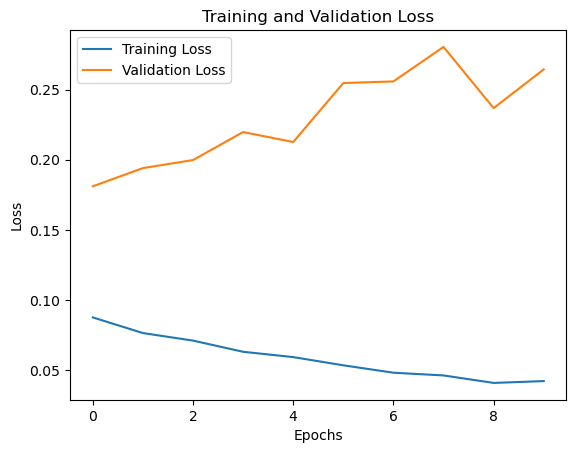

In [19]:
import matplotlib.pyplot as plt

history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


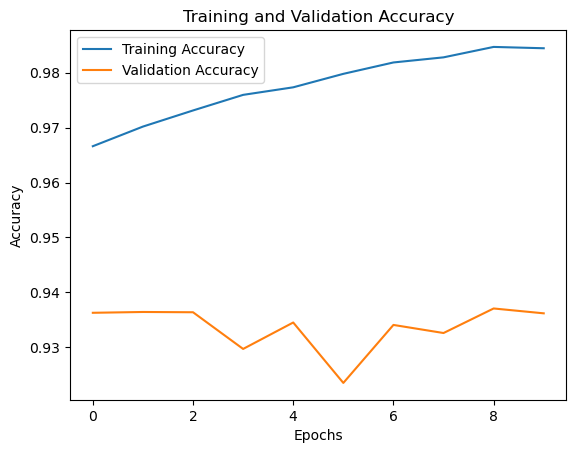

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

636/636 [==============================] - 7s 10ms/step


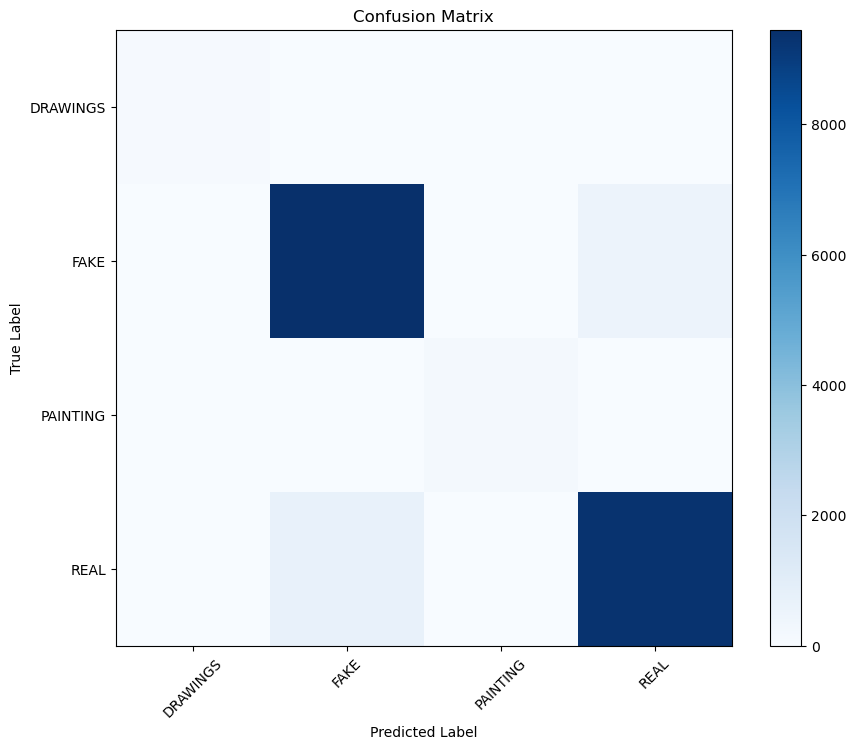

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np

predicted_labels = model.predict(test_dataset).argmax(axis=1)
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=45)
plt.yticks(tick_marks, label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, predicted_labels, target_names=label_names)
print(report)

              precision    recall  f1-score   support

    DRAWINGS       0.78      0.87      0.82       122
        FAKE       0.93      0.94      0.94     10000
    PAINTING       0.96      0.85      0.90       228
        REAL       0.94      0.93      0.94     10000

    accuracy                           0.94     20350
   macro avg       0.90      0.90      0.90     20350
weighted avg       0.94      0.94      0.94     20350

